<sub>Mario Stanke, University of Greifswald, Germany</sub>
# Exercise Set 1 - A Quadratic Model
<sup>(Monday morning)</sup>

In this notebook we extend the solution from the previous exercise (different loss) to a quadratic prediction function 
$$t = h_{\pmb{\theta}}({\bf x}) := \theta_0 + \theta_1 x_1 + \theta_2 x_1^2.$$

The loss function remains $ \ell(y, t) = 5 \cdot \texttt{relu}(y-t) + \texttt{relu}(t-y)$.

**Instructions:**

 1. Run the whole notebook to produce the results from the linear fit at first.
 2. 

### Implement $\ell(y, t)$ with tensorflow functions.

In [1]:
# First import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
def ell(y, t):
    '''
        Input: y and t are vectors of the same size.
        Output: vector of 5 * relu(y-t) + relu(t-y) applied to each component of y and t
    '''
    return 5 * tf.nn.relu(y - t) + tf.nn.relu(t - y)

# load the training data from the table file to a pandas data frame
df = pd.read_csv("../bikes-summerdays.tbl", sep='\s+')

# convert count data to floats as regression target
df['count'] = df['count'].astype(float) 

m, n_cols = df.shape # training set size and number of columns 

# compute average of hourly bike rental counts
meancount = np.mean(df['count'])

In [5]:
def scatterplot_rentals():
    ''' Plot the bike rental counts versus the temperature.'''
    _, ax = plt.subplots()
    ax.scatter(df["temp"], df["count"])
    plt.title("bike rentals versus temperature")
    plt.xlabel('temperature [' + r'$^\circ$' + 'C]')
    plt.ylabel('rental count per hour');
    return ax

## Create Original Data Matrix $X$ and response vector $y$

In [38]:
# extract response vector
y_train = np.array(df['count']) 

# extract feature columns
n = n_cols - 1 # number of features
temps = np.array(df.loc[:, df.columns != 'count']) # matrix of all other columns (here only one col)

# make data matrix X
X_train = np.ones((m, n+1)) # initialize with all ones
# overwrite all but the zero-th column with features
X_train[:,1:n+1] = temps / 10 - 2.5 # normalize temperatures so they are roughly in [-1,1] 

## 1. Compute Data Matrix with Squares
Use tensorflow to compute a matrix
$$\begin{pmatrix}
1 & x^{(1)}_1 & (x^{(1)}_1)^2\\
\vdots & \vdots & \vdots \\ 
1 & x^{(m)}_1 & (x^{(m)}_1)^2\\
\end{pmatrix}$$
and call it again ```X_train```. This can be achieved by concatenating the original ```X_train``` with an $m \times 1$ matrix that contains the elementwise squares of column number 1 of original ```X_train```.  
*Tipp:* [tf.concat](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/concat)

In [41]:
if (X_train.shape[1] == 1): # avoid adding the extra column more than once
    # ADD YOUR CODE HERE
    X_train = tf.concat([X_train, X_train[:,[1]]**2], axis=1)
print("X_train:\n", X_train[0:5].numpy())
# Note: The remainder of the notebook can be run regardless of whether X_train has 2 or 3 columns.

X_train:
 [[ 1.       -1.188     1.411344]
 [ 1.       -1.188     1.411344]
 [ 1.       -1.188     1.411344]
 [ 1.       -1.106     1.223236]
 [ 1.       -1.024     1.048576]]


**Solution:**
```
X_train:
[[ 1.       -1.188     1.411344]
 [ 1.       -1.188     1.411344]
 [ 1.       -1.188     1.411344]
 [ 1.       -1.106     1.223236]
 [ 1.       -1.024     1.048576]]
```

## Solution 2: High-Level

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate = .1, nesterov=False, momentum = 0.9)
# SGD: stochastic gradient descent
loss_object = tf.keras.losses.MeanSquaredError() # unneccessary, once own loss is used

In [44]:
np.random.seed(1)
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(m).batch(32) # random order

In [45]:
# Get a predefined linear model with one single output variable (unit) and one weight per input.
# Default is random initialization.
model = tf.keras.layers.Dense(units = 1,
                              use_bias = False, # bias equivalent to adding x_0 := 1
                              dtype = 'float64')

In [46]:
# one gradient descent step
def train_step(x, y):
    with tf.GradientTape() as tape:
        t = model(x) # predicted rental demand
        t = tf.reshape(t, [-1])
        # YOUR CODE HERE, replace the following line with a call to your own loss function ell
        # REMEMBER TO take the average, too, so E is a scalar.
        # E = loss_object(y, t)
        E = ell(y, t)
        E = tf.reduce_mean(E)
        # END OF YOUR CODE

    grads = tape.gradient(E, model.trainable_variables)
    # this makes a parameter update using the gradient
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return E

In [47]:
# optimize the parameters
for epoch in range(100):
    for batchnumber, (x, y) in enumerate(dataset):
        E = train_step(x, y)

In [48]:
print("theta:\n", model.trainable_variables[0].numpy())
# make final prediction on all training data
t = tf.reshape(model(X_train2), [m])
print ("Loss = ", tf.reduce_mean(ell(y_train, t)))

theta:
 [[ 509.93648062]
 [ 158.51534894]
 [-127.50624792]]
Loss =  tf.Tensor(280.21909033005124, shape=(), dtype=float64)


## Plot predictions

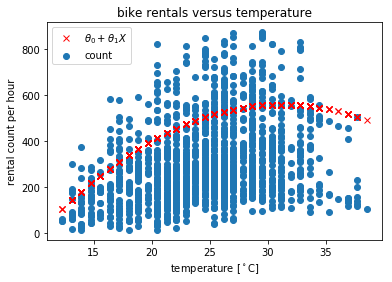

In [24]:
# draw the same scatterplot as above
ax = scatterplot_rentals()

# now add the predictions, here a regression line
label = r"$\theta_0 + \theta_1 X$" 
ax.plot(temps, t, 'rx', label=r"$\theta_0 + \theta_1 X$") # (r)ed crosses (x)
ax.legend(loc = 'upper left');